In [31]:
%load_ext autoreload
%autoreload 2


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [32]:
import chess
from sarfa import core, BoardVisualization, SarfaBaseline, Engine, RemovalPerturber
from IPython.display import Image, display
from collections import defaultdict

# Visualization Testing

In [33]:
FEN = '6k1/2n1b1r1/r1q1p1p1/2p1PpNp/1pP2P1P/pP1RB3/P2Q2P1/3R2K1 w - - 0 1'
action = ''

In [34]:
board = chess.Board(FEN)
engine = Engine("./stockfish_15_x64_avx2")
board_visualization = BoardVisualization(board)


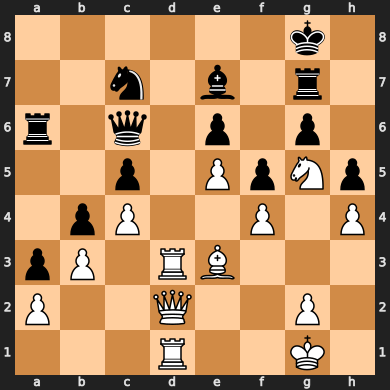

In [35]:
board_visualization.only_board()

# Sarfa (without defined action)

In [11]:
saliency_results: dict[str, float] = defaultdict(int)
perturber = RemovalPerturber(board)
saliency_calculator = SarfaBaseline(engine, board)
for perturbed_board, perturbed_position_str in perturber.process():

    saliency: float = saliency_calculator.compute(perturbed_board, None)
    saliency_results[perturbed_position_str] = saliency
    print(f"{perturbed_position_str} removed: {saliency}")

a2 removed: 0.37637367245957526
a3 removed: 0.18991181838911175
a6 removed: 0
b3 removed: 0.3767510182782542
b4 removed: 0.10160145826184686
c4 removed: 0.34710227574269653
c5 removed: 0.49602919513643884
c6 removed: 0
c7 removed: 0
d1 removed: 0.3795131272892437
d2 removed: 0.37188645022102
d3 removed: 0.47928063261314224
e3 removed: 0.3636930820098805
e5 removed: 0.36758496576097577
e6 removed: 0.019247430326575596
e7 removed: 0
f4 removed: 0.43174821445553146
f5 removed: 0.38094097272427807
g2 removed: 0.3745530597845854
g5 removed: 0.35710189868800246
g6 removed: 0.24043640717406795
g7 removed: 0
h4 removed: 0.4148144574531723
h5 removed: 0.2644375926722479


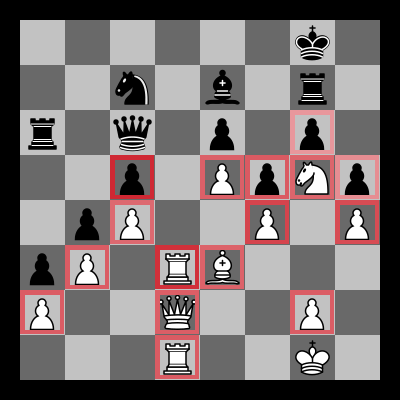

In [12]:
path = board_visualization.show_heatmap(saliency_results, None)
display(Image(path))

# Sarfa Baseline with Move

In [ ]:
action: chess.Move = chess.Move.from_uci("e3f2")

In [ ]:
saliency_results: dict[str, float] = defaultdict(int)
perturber = RemovalPerturber(board)
saliency_calculator = SarfaBaseline(engine, board)
for perturbed_board, perturbed_position_str in perturber.process():

    saliency: float = saliency_calculator.compute(perturbed_board, action)
    saliency_results[perturbed_position_str] = saliency


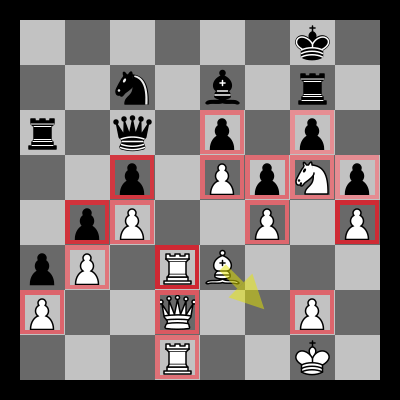

In [ ]:
path = board_visualization.show_heatmap(saliency_results, action)
display(Image(path))

# Benchmarking

In [36]:
from chess_dataset import SafraBenchmark
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

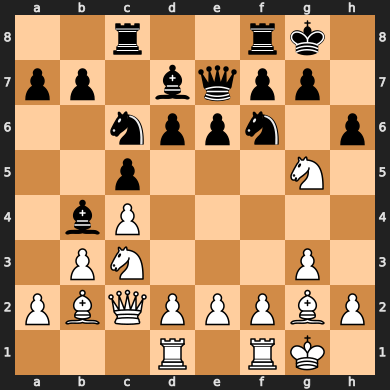

In [42]:
board = chess.Board('2r2rk1/pp1bqpp1/2nppn1p/2p3N1/1bP5/1PN3P1/PBQPPPBP/3R1RK1 w - - 0 1')
board

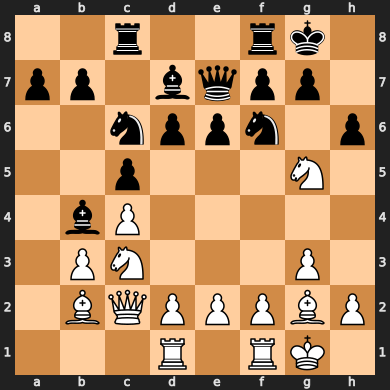

In [43]:
fen2 = '2r2rk1/pp1bqpp1/2nppn1p/2p3N1/1bP5/1PN3P1/1BQPPPBP/3R1RK1 w - - 0 1'
board2 = chess.Board(fen2)
board2

In [45]:
chess.Move.from_uci('c3d5') in board2.legal_moves

True

In [57]:
def saliency_algorithm(fen, action=None):
    board = chess.Board(fen)

    saliency_results: dict[str, float] = defaultdict(int)
    perturber = RemovalPerturber(board)
    saliency_calculator = SarfaBaseline(engine, board)
    for perturbed_board, perturbed_position_str in perturber.process():
        saliency: float = saliency_calculator.compute(perturbed_board, 
        action)
        saliency_results[perturbed_position_str] = saliency

    return saliency_results


In [58]:
benchmark = SafraBenchmark(saliency_algorithm)

0
1
2


In [59]:
benchmark.accuracy()

{'accuracy - harmonic_mean': 0.6264576319450209}

In [60]:
fpr, tpr = benchmark.roc_curve()
roc_auc = auc(fpr, tpr)


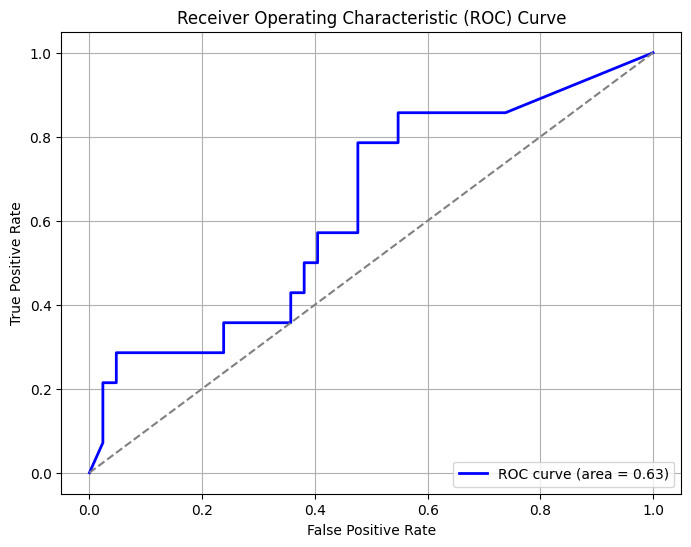

In [61]:
# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # Random classifier line (diagonal)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

# Sequential SARFA

In [9]:
def sequential_saliency_algorithm(fen, discount_factor, depth):
    board = chess.Board(fen)

    saliency_results: dict[str, float] = defaultdict(int)
    perturber = RemovalPerturber(board)
    saliency_calculator = SarfaBaseline(engine, board)
    saliency_results_per_step = []
    for curr_step in range(0, depth):
        print(f"curr step: {curr_step}")
        for perturbed_board, perturbed_position_str in perturber.process():
            saliency: float = saliency_calculator.compute(perturbed_board, None)
            saliency_results[perturbed_position_str] += (saliency * (discount_factor ** curr_step))

        saliency_results_per_step.append((saliency_results.copy(), board.copy()))

    return saliency_results, saliency_results_per_step

In [10]:
fen = '6k1/2n1b1r1/r1q1p1p1/2p1PpNp/1pP2P1P/pP1RB3/P2Q2P1/3R2K1 w - - 0 1'
discount_factor = 0.9
depth = 3
saliency_results, saliency_results_per_step = sequential_saliency_algorithm(fen, discount_factor, depth)

curr step: 0
curr step: 1
curr step: 2


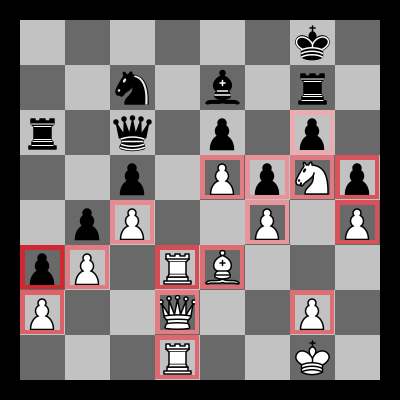

In [17]:
step = 0
board_visualization = BoardVisualization(saliency_results_per_step[step][1])
path = board_visualization.show_heatmap(saliency_results_per_step[step][0], None)
display(Image(path))

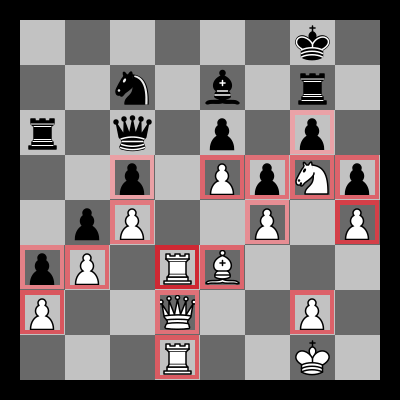

In [18]:
step = 1
board_visualization = BoardVisualization(saliency_results_per_step[step][1])
path = board_visualization.show_heatmap(saliency_results_per_step[step][0], None)
display(Image(path))

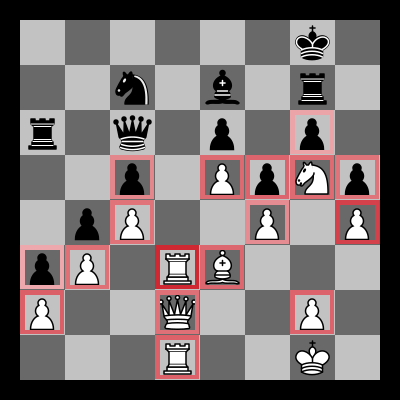

In [19]:
step = 2
board_visualization = BoardVisualization(saliency_results_per_step[step][1])
path = board_visualization.show_heatmap(saliency_results_per_step[step][0], None)
display(Image(path))